# Spatial analysis of viral regions
**20201013, cmdoret**

I have extracted the positions of viral sequences in the A. castellanii assemblies of C3 and Neff strains and retrieved the contact profile of those regions. Visual inspection of the map hinted that some of the viral integration may have an insulating potential.

Here I quantify and visualise those contact profiles and inspect what is the genetic neighbourhood of those viral regions.

In [88]:
from os.path import join
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
VIRDAT = '../../data/out/virus/'
strains = ["C3", "Neff"]

# All data structs will be nested in a dictionary with strain as key.
# This makes generation harder to read, but querying more convenient
# {str: df}
borders = {s: pd.read_csv(join(VIRDAT, 'spatial', f'{s}_borders.tsv'), sep='\t') for s in strains}
# {str: {id: np.array[i,j]}}
pileups = {s: json.load(open(join(VIRDAT, 'spatial', f'{s}_borders.json'))) for s in strains}
for s in pileups.keys(): pileups[s] = {int(i): np.array(w) for i, w in pileups[s].items()}

# Make an empty 3D array of shape N_coords x height x width
# {str: np.array[i,j,k]}
win_arr = {s: np.zeros((len(pileups[s].items()), *pileups[s][0].shape)) for s in pileups.keys()}
# Fill the 3D array with windows values
for s in pileups.keys():
    for i, w in pileups[s].items():
        win_arr[s][i] = w

# Drop positions with NaN scores
for s in strains:
    valid_mask = ~np.isnan(borders[s].score)
    borders[s] = borders[s].loc[valid_mask, :]
    borders[s] = borders[s].reset_index(drop=True)
    win_arr[s] = win_arr[s][valid_mask, :, :]

<IPython.core.display.Javascript object>


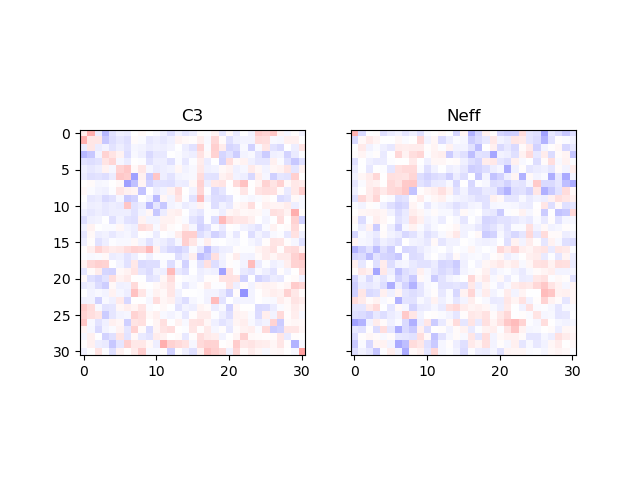

<ipython-input-128-937624133ac1>:6: RuntimeWarning: Mean of empty slice
  pileup = np.nanmean(wins, axis=0)


In [128]:
%matplotlib notebook
# Perhaps there is some faint insulation signal in Neff (losing with median)
# -> subset of insulating viral regions ?
def make_pileup(wins):
    if len(wins.shape) == 3:
        pileup = np.nanmean(wins, axis=0)
    else:
        pileup = wins
    pileup = np.nan_to_num(pileup)
    pileup = pileup + np.transpose(pileup) - np.diag(np.diag(pileup))
    return np.log2(pileup)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
for i, s in enumerate(strains):
    ax[i].imshow(make_pileup(win_arr[s]), cmap='bwr', vmin=-1, vmax=1)
    ax[i].set_title(s)

<IPython.core.display.Javascript object>


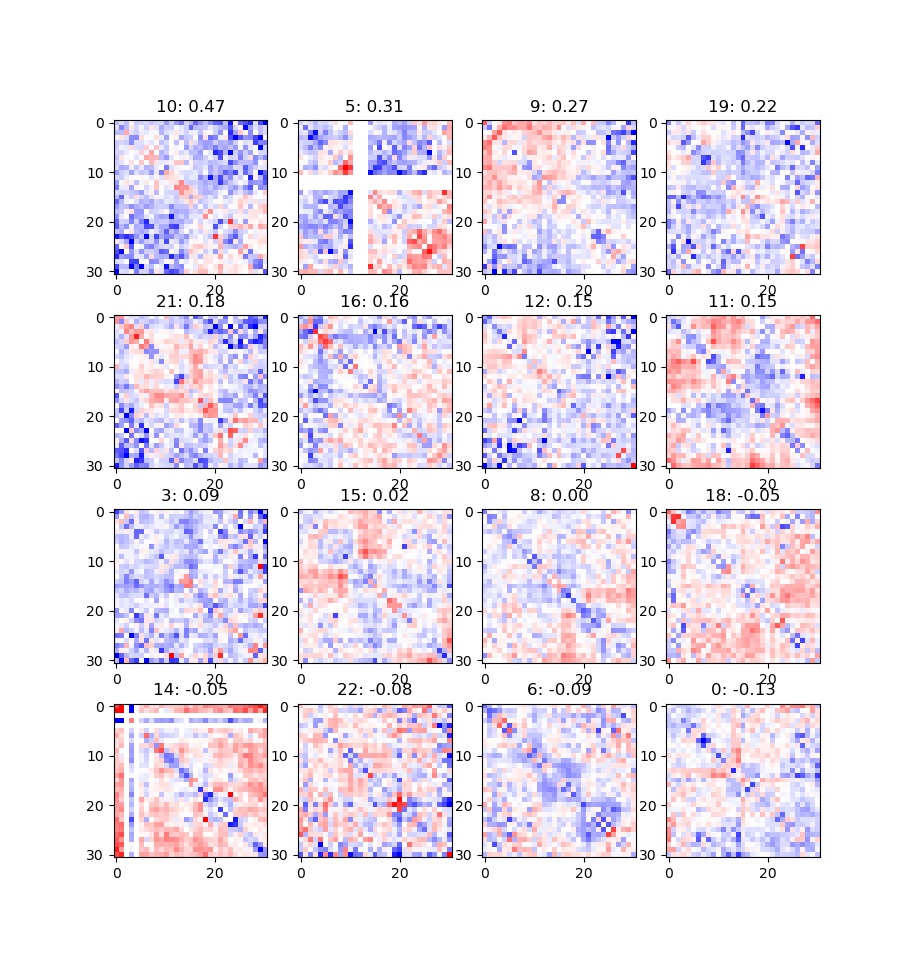

<ipython-input-128-937624133ac1>:11: RuntimeWarning: divide by zero encountered in log2
  return np.log2(pileup)


In [162]:
%matplotlib notebook
# Windows 10, 9, 11 seem to have some insulation
# Misassemblies on windows 4, 20, 17
fig, ax = plt.subplots(4, 4)
for i, axi in zip(np.argsort(borders['C3'].score.values)[::-1][:16], ax.flat):
                    axi.imshow(make_pileup(win_arr['C3'][i, :, :]), cmap='bwr', vmin=-2, vmax=2)
                    axi.set_title(f"{i}: {borders['C3'].score[i]:.2f}")

<IPython.core.display.Javascript object>


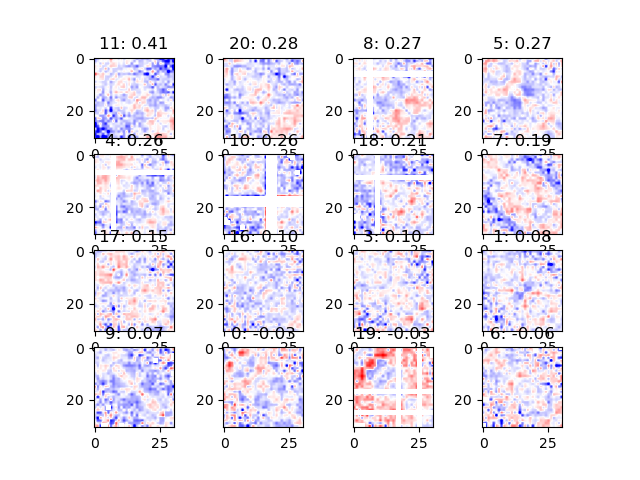

<ipython-input-128-937624133ac1>:11: RuntimeWarning: divide by zero encountered in log2
  return np.log2(pileup)


In [161]:
%matplotlib notebook
# images 5, 8, 20 seem to have good insulation
fig, ax = plt.subplots(4, 4)
for i, axi in zip(np.argsort(borders['Neff'].score.values)[::-1][:16], ax.flat):
                    axi.imshow(make_pileup(win_arr['Neff'][i, :, :]), cmap='bwr', vmin=-2, vmax=2)
                    axi.set_title(f"{i}: {borders['Neff'].score[i]:.2f}")

In [159]:
np.argsort(borders['Neff'].score.values)[:16:-1][:16]

array([11, 20,  8,  5])

### Manual inspection of viral regions
Here I look at the neighbourhood of viral regions that have strong insulation as reported by chromosight _and_ that look like borders.

In [140]:
insul = {'C3': [9, 10, 11], 'Neff': [5, 8, 20]}

In [ ]:
def get_neighbourhood(chrom, pos, size=1000):
    """Given a position, return annotations falling in the neighbourhood"""
    over_left  = (annot.start <= pos + size) & (annot.start > pos - size)
    over_right = (annot.end   >  pos - size) & (annot.end   < pos + size)
    same_chrom = annot.chrom == chrom
    return annot.loc[same_chrom & (over_left | over_right), :]

In [163]:
%matplotlib notebook

plt.imshow(make_pileup(win_arr['Neff'][5, :, :]))

NameError: name 'promi' is not defined